Import all the required libraries for Naive Bayes and Deep Learning Models

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import adam_v2, rmsprop_v2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

Import pandas Read the dataset and displaying top 5 rows

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/SPl Topics ML in Info sec/spam.csv', encoding='ISO-8859-1') # reading the csv file using pandas dataframe.
df = df[['v1', 'v2']]
df.columns = ["classification", "sentences"]
df.head()

,classification,sentences
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Labelled the dataset with ham to 0 and spam to 1

In [ ]:
for ind in range(df.shape[0]):
  if df.iloc[ind][0] == "ham":
    df.loc[ind, "label"] = str(0)
  else:
    df.loc[ind, "label"] = str(1)

df.head()

,classification,sentences,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


created the list of sentences and lables

In [ ]:
df["v1"]=df["classification"].map({'spam':1,'ham':0}) # mapping spam to 1 and ham to 0
labels_list = [val for val in range(df.shape[0])] 
unCleaned_sentences = [df.iloc[ind][1] for ind in range(df.shape[0])] # uncleaned sentences

Imported string library, changed all the text to lower case and cleaned the punctuations in all sentences.

In [ ]:
import string

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))

sentences_list = []
for text in unCleaned_sentences:
  text = text.lower()
  sentences_list.append(text.translate(remove_punct_map))  # cleaning of sentences.

len(sentences_list)

Imported nltk library and downloaded the stopwords and removed it from each sentences

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

sentences = []
for sent in sentences_list:
  text_tokens = word_tokenize(sent)
  sentences.append([word for word in text_tokens if not word in stopwords.words()]) # removing stop words from each senetence.

sentences

Imported Lemmatizer from nltk and lemmatized each word for each sentence in the corpus.

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')  # downloaded wordnet corpus data which is reference to lemmatization.

lemt_sentences = []
for sent in sentences:
  sent_l = []
  for word in sent:
    sent_l.append(wordnet_lemmatizer.lemmatize(word)) # lemmatizing each word in sentence.
  lemt_sentences.append(sent_l) # adding lemmatized sentences to list.

Tokenizing all the words in the corpus of data, converted texts to sequences for all sentences in the data.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lemt_sentences)
sequences = tokenizer.texts_to_sequences(lemt_sentences)

vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

8764


Displayed the word length of all sentences in the corpus of data.

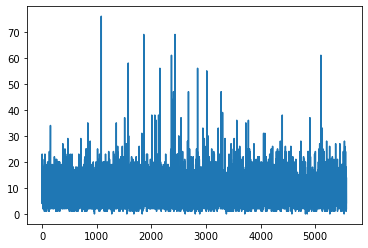

In [ ]:
plotval = [len(val) for val in sequences]

plt.plot(plotval)

Percentage of sentences with length of words less than or equal to 20 is 95.8%

In [ ]:
sum_val = [1 if val <= 20 else 0 for val in plotval]
sum(sum_val)/len(sum_val)

0.9589016511127064

each sequence is fixed to constant length of 20, by truncating and padding the sequences at the end of each sentence.

In [ ]:
pad = 'post' 
max_len = 20  # based on above analysis max length of words in a sentence is taken as 20.
embedding_size = 100    # Embedding dimension 
batch_size = 20 # batch size sent as input to neural network

sequences = pad_sequences(sequences, maxlen=max_len, padding=pad, truncating=pad) # post padding and truncating done to make sequence length of 20.

print(sequences.shape) # we got 5572 sequence with each sequence lenght of 20

X_train, X_test, y_train, y_test = train_test_split(sequences, df["v1"], test_size = 0.3, random_state= 42) 

(5572, 20)


Displayed the bar plot of counts of spam and ham in the dataset.

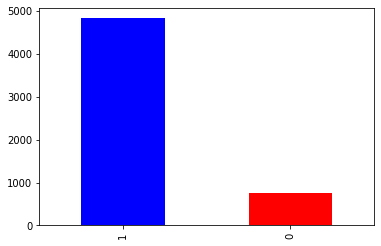

In [ ]:
import matplotlib.pyplot as plt

dist_output_counts = df['label'].value_counts()

dist_output_counts.plot(kind='bar', color=['blue', 'red'])

plt.show()

Percentage distribution of spam and ham in dataset

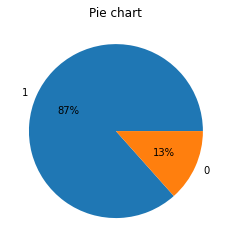

In [ ]:
dist_output_counts.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()


Dispayed the top five more frequent words in the sentences of dataset which are part of ham

In [ ]:
from collections import Counter

v = " ".join(df[df['classification'] == 'ham']['sentences']).split()
traindf = Counter(v).most_common(20)

traindf = pd.DataFrame.from_dict(traindf)

traindf = traindf.rename(columns={0: "words in ham", 1: "counts"})
traindf.head()

,words in ham,counts
0,to,1530
1,you,1458
2,I,1436
3,the,1019
4,a,969


Dispayed the top five more frequent words in the sentences of dataset which are part of spam

In [ ]:
s = Counter(" ".join(df[df['classification'] == 'spam']['sentences']).split()).most_common(20)

df2 = pd.DataFrame.from_dict(s)
df2 = df2.rename(columns={0: "words in spam", 1: "count"})
df2.head()

,words in spam,count
0,to,604
1,a,358
2,your,187
3,call,185
4,or,185


Dispayed the top 10 more frequent words in the sentences of dataset which are part of ham

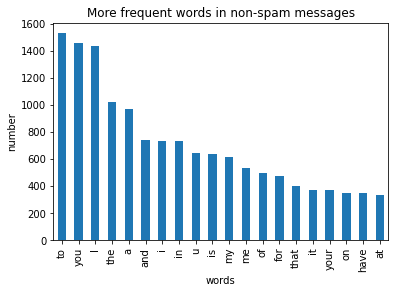

In [ ]:
import numpy as np

traindf.plot.bar(legend = False)
y_pos = np.arange(len(traindf["words in ham"]))
plt.xticks(y_pos, traindf["words in ham"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

Dispayed the top 10 more frequent words in the sentences of dataset which are part of spam

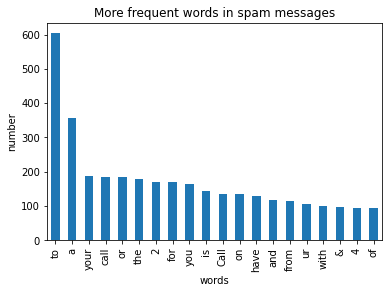

In [ ]:
df2.plot.bar(legend = False)
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

Imported feature_extraction and created count vectorizer for stop words in english and transformed the data

In [ ]:
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

f = feature_extraction.text.CountVectorizer(stop_words = 'english')

X = f.fit_transform(df['sentences']) # converted all sentences to vectors

np.shape(X)

(5572, 8404)

splitted the input data to train 80% and test 20% with random state 42 

In [ ]:
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(X, df["v1"], test_size = 0.3, random_state= 42) 

calculated the scores various alphas to identify the best alpha for multinomiual naive bayes.

In [ ]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(nb_X_train, nb_y_train)
    score_train[count] = bayes.score(nb_X_train, nb_y_train)
    score_test[count]= bayes.score(nb_X_test, nb_y_test)
    recall_test[count] = metrics.recall_score(nb_y_test, bayes.predict(nb_X_test))
    precision_test[count] = metrics.precision_score(nb_y_test, bayes.predict(nb_X_test))
    count = count + 1

Displayed matrix of scores for train and test data to identify the best alpha

In [ ]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
matrix

models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998205,0.974888,0.920000,0.896104
1,0.11001,0.997083,0.974888,0.940000,0.881250
2,0.22001,0.997083,0.975785,0.933333,0.891720
3,0.33001,0.996186,0.973991,0.933333,0.880503
4,0.44001,0.995961,0.976682,0.940000,0.892405
5,0.55001,0.995513,0.974888,0.926667,0.891026
6,0.66001,0.995513,0.978475,0.926667,0.914474
7,0.77001,0.995288,0.979372,0.926667,0.920530
8,0.88001,0.995064,0.979372,0.926667,0.920530
9,0.99001,0.995064,0.979372,0.926667,0.920530


Identify the alpha for best test precision

In [ ]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             17.930010
Train Accuracy     0.978461
Test Accuracy      0.968610
Test Recall        0.766667
Test Precision     1.000000
Name: 163, dtype: float64

Display top five best alpha with test precision 1

In [ ]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
163,17.93001,0.978461,0.96861,0.766667,1.0
164,18.04001,0.978461,0.96861,0.766667,1.0
165,18.15001,0.978461,0.96861,0.766667,1.0
166,18.26001,0.978461,0.96861,0.766667,1.0
167,18.37001,0.978461,0.96861,0.766667,1.0


calculated the best alpha with test precision 1 and best test accuracy

In [ ]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(nb_X_train, nb_y_train)
models.iloc[best_index, :]

alpha             17.930010
Train Accuracy     0.978461
Test Accuracy      0.968610
Test Recall        0.766667
Test Precision     1.000000
Name: 163, dtype: float64

calculated the confusion matrix for test naive bayes dataset

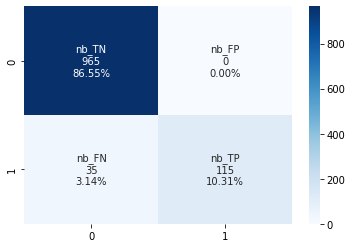

In [ ]:
nb_pred = bayes.predict(nb_X_test)
nb_cm = metrics.confusion_matrix(nb_y_test, bayes.predict(nb_X_test))

import seaborn as sns

group_names = ['nb_TN','nb_FP','nb_FN','nb_TP']
group_counts = ["{0:0.0f}".format(value) for value in
                nb_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     nb_cm.flatten()/np.sum(nb_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
nb_labels = np.asarray(labels).reshape(2,2)
sns.heatmap(nb_cm, annot=nb_labels, fmt='', cmap='Blues')

calculated the roc curve for naive bayes classifier

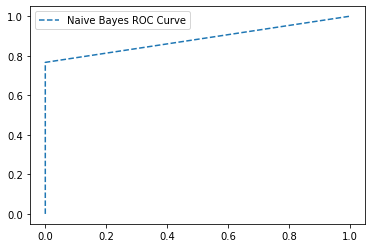

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

nb_fpr, nb_tpr, _ = roc_curve(nb_y_test, nb_pred)

plt.plot(nb_fpr, nb_tpr, linestyle='--', label='Naive Bayes ROC Curve')
plt.legend()

calculated the PR Curve for naive bayes classifier

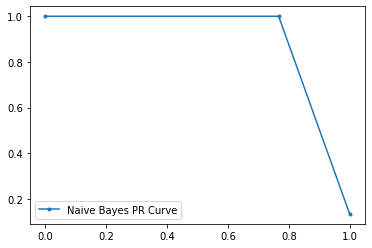

In [ ]:
nb_precision, nb_recall, _ = precision_recall_curve(nb_y_test, nb_pred)

plt.plot(nb_recall, nb_precision, marker='.', label='Naive Bayes PR Curve')
plt.legend()


Imported the libraries for deep learning models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import adam_v2, rmsprop_v2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils.vis_utils import plot_model


created sequential model for lstm

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))

model.add(LSTM(140, return_sequences=False))

model.add(Dense(1, activation='sigmoid', name='Classification'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 100)           876400    
                                                                 
 lstm_6 (LSTM)               (None, 140)               134960    
                                                                 
 Classification (Dense)      (None, 1)                 141       
                                                                 
Total params: 1,011,501
Trainable params: 1,011,501
Non-trainable params: 0
_________________________________________________________________


Displayed plot for the created sequential model

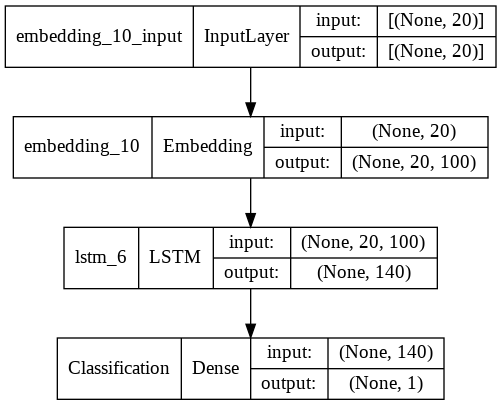

In [ ]:
plot_model(model, "model.png", show_shapes=True)

compiled model with loss functions, optimizers and metrics.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

trained model with 10 epochs

In [ ]:
n_epochs = 10
results = model.fit(np.array(X_train), np.array(y_train), epochs=n_epochs, batch_size=batch_size, verbose=1)

Epoch 1/10
223/223 [==============================] - 13s 47ms/step - loss: 0.1212 - accuracy: 0.9554
Epoch 2/10
223/223 [==============================] - 10s 46ms/step - loss: 0.0221 - accuracy: 0.9955
Epoch 3/10
223/223 [==============================] - 10s 46ms/step - loss: 0.0169 - accuracy: 0.9957
Epoch 4/10
223/223 [==============================] - 10s 45ms/step - loss: 0.0030 - accuracy: 0.9996
Epoch 5/10
223/223 [==============================] - 10s 45ms/step - loss: 2.0765e-04 - accuracy: 1.0000
Epoch 6/10
223/223 [==============================] - 11s 48ms/step - loss: 6.0437e-05 - accuracy: 1.0000
Epoch 7/10
223/223 [==============================] - 10s 46ms/step - loss: 4.1312e-05 - accuracy: 1.0000
Epoch 8/10
223/223 [==============================] - 10s 46ms/step - loss: 3.0255e-05 - accuracy: 1.0000
Epoch 9/10
223/223 [==============================] - 10s 46ms/step - loss: 2.3099e-05 - accuracy: 1.0000
Epoch 10/10
223/223 [==============================] - 10s 46m

Evaluated lstm model on test data

In [ ]:
eval_ = model.evaluate(np.array(X_test), np.array(y_test))
print(eval_[0], eval_[1]) # loss / accuracy

35/35 [==============================] - 1s 10ms/step - loss: 0.1139 - accuracy: 0.9839
0.11389583349227905 0.9838564991950989


Calculated predicted outputs for lstm

In [ ]:
lstm_pred = [1 if val > 0.5 else 0 for val in model.predict(np.array(X_test))]

confusion matrix for lstm predicted and actual output

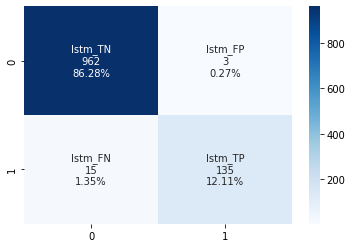

In [ ]:
lstm_cm = metrics.confusion_matrix(y_test, lstm_pred)
# pd.DataFrame(data = cm, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
group_names = ['lstm_TN','lstm_FP','lstm_FN','lstm_TP']
group_counts = ["{0:0.0f}".format(value) for value in
                lstm_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     lstm_cm.flatten()/np.sum(lstm_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
lstm_labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lstm_cm, annot=lstm_labels, fmt='', cmap='Blues')

ROC curve for lstm calculated output

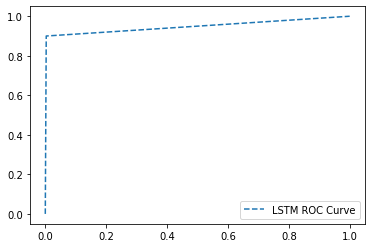

In [ ]:
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)

plt.plot(lstm_fpr, lstm_tpr, linestyle='--', label='LSTM ROC Curve')
plt.legend()

PR Curve for LSTM calculated output

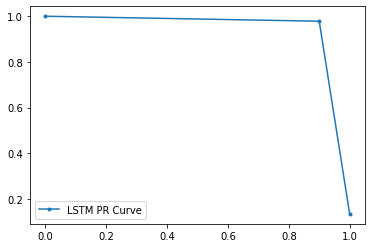

In [ ]:
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test, lstm_pred)

plt.plot(lstm_recall, lstm_precision, marker='.', label='LSTM PR Curve')
plt.legend()


created sequential model for GRU and trained for input training data

---



In [ ]:
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model1.add(Dropout(0.8))
model1.add(GRU(140, return_sequences=False))
model1.add(Dropout(0.86))
model1.add(Dense(1, activation='sigmoid', name='Classification'))
model1.summary()

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results1 = model1.fit(np.array(X_train), np.array(y_train), epochs=n_epochs, batch_size=batch_size, validation_split=0.2)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 20, 100)           876400    
                                                                 
 dropout_16 (Dropout)        (None, 20, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 140)               101640    
                                                                 
 dropout_17 (Dropout)        (None, 140)               0         
                                                                 
 Classification (Dense)      (None, 1)                 141       
                                                                 
Total params: 978,181
Trainable params: 978,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
179/179 [===========================

Printed the plot for GRU model

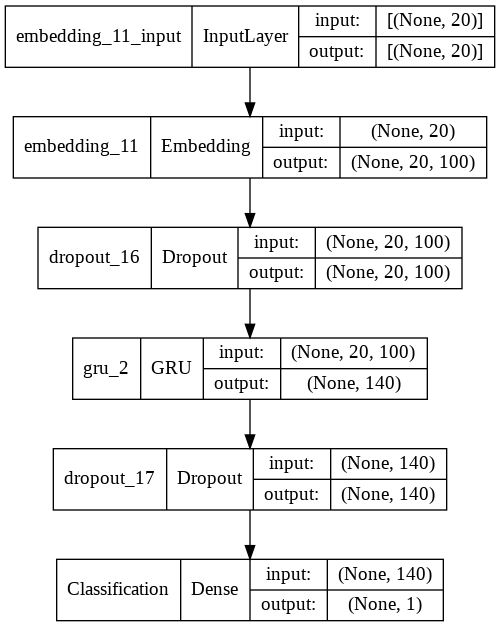

In [ ]:
plot_model(model1, "model1.png", show_shapes=True)

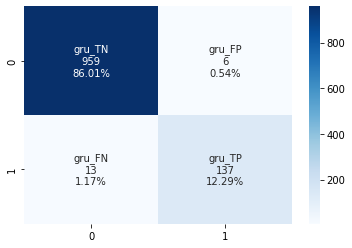

In [ ]:
gru_pred = [1 if val > 0.5 else 0 for val in model1.predict(np.array(X_test))]

gru_cm = metrics.confusion_matrix(y_test, gru_pred)
# pd.DataFrame(data = gru_cm, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

group_names = ['gru_TN','gru_FP','gru_FN','gru_TP']
group_counts = ["{0:0.0f}".format(value) for value in
                gru_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     gru_cm.flatten()/np.sum(gru_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
gru_labels = np.asarray(labels).reshape(2,2)
sns.heatmap(gru_cm, annot=gru_labels, fmt='', cmap='Blues')

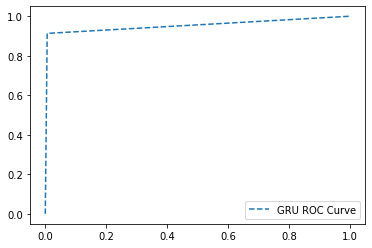

In [ ]:
gru_fpr, gru_tpr, _ = roc_curve(y_test, gru_pred)

plt.plot(gru_fpr, gru_tpr, linestyle='--', label='GRU ROC Curve')
plt.legend()

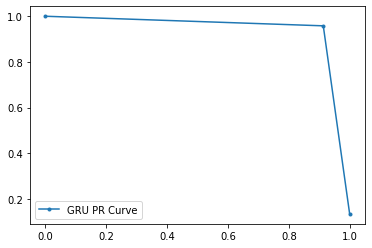

In [ ]:
gru_precision, gru_recall, _ = precision_recall_curve(y_test, gru_pred)

plt.plot(gru_recall, gru_precision, marker='.', label='GRU PR Curve')
plt.legend()

created sequential model for Bi-Directional LSTM and trained for input training data


In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model2.add(Dropout(0.8))
model2.add(Bidirectional(LSTM(140, return_sequences=False)))
model2.add(Dropout(0.8))
model2.add(Dense(1, activation='sigmoid', name='Classification'))
model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

results2 = model2.fit(np.array(X_train), np.array(y_train), epochs=n_epochs, batch_size=batch_size, validation_split=0.2)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 100)           876400    
                                                                 
 dropout_18 (Dropout)        (None, 20, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 280)              269920    
 nal)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 280)               0         
                                                                 
 Classification (Dense)      (None, 1)                 281       
                                                                 
Total params: 1,146,601
Trainable params: 1,146,601
Non-trainable params: 0
___________________________________________

Plotted the graph for input model of Bi-Directional lstm

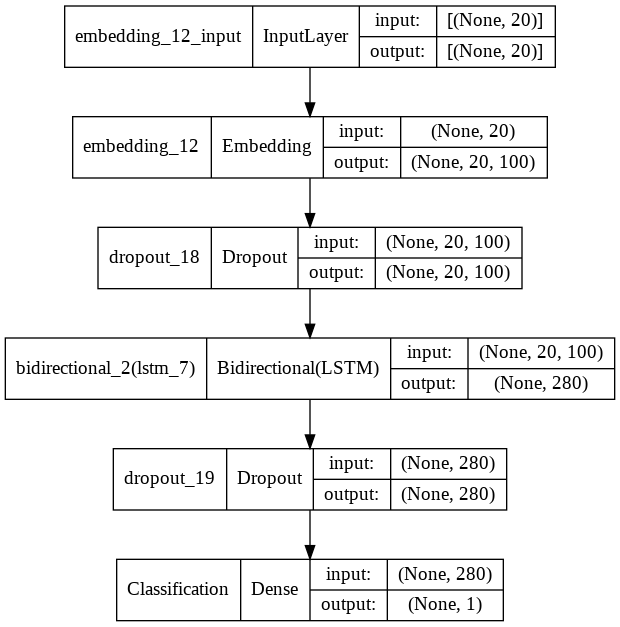

In [ ]:
plot_model(model2, "model2.png", show_shapes=True)

Confusion matrix for Bi-Directional lstm output

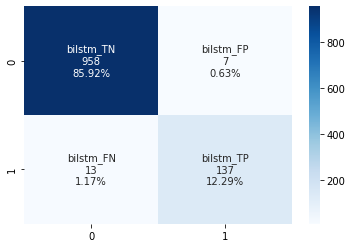

In [ ]:
bilstm_pred = [1 if val > 0.5 else 0 for val in model2.predict(np.array(X_test))]

bilstm_cm = metrics.confusion_matrix(y_test, bilstm_pred)

group_names = ['bilstm_TN','bilstm_FP','bilstm_FN','bilstm_TP']
group_counts = ["{0:0.0f}".format(value) for value in
                bilstm_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     bilstm_cm.flatten()/np.sum(bilstm_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
bilstm_labels = np.asarray(labels).reshape(2,2)
sns.heatmap(bilstm_cm, annot=bilstm_labels, fmt='', cmap='Blues')

Bi-Directional lstm output ROC curve

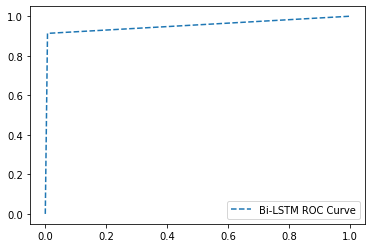

In [ ]:
bilstm_fpr, bilstm_tpr, _ = roc_curve(y_test, bilstm_pred)

plt.plot(bilstm_fpr, bilstm_tpr, linestyle='--', label='Bi-LSTM ROC Curve')
plt.legend()

Bi-Directional output PR Curve

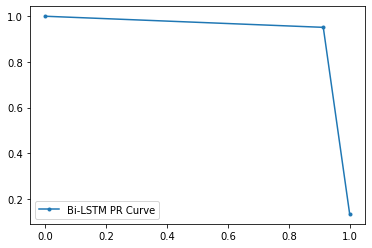

In [ ]:
bilstm_precision, bilstm_recall, _ = precision_recall_curve(y_test, bilstm_pred)

plt.plot(bilstm_recall, bilstm_precision, marker='.', label='Bi-LSTM PR Curve')
plt.legend()

Convolutional Neural Network Model and training

In [ ]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPool1D(3))
model3.add(Dropout(0.2))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.summary()
model3.add(Dense(1, activation='sigmoid'))


model3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result3 = model3.fit(np.array(X_train), np.array(y_train), batch_size = batch_size, epochs=n_epochs, validation_split=0.2, verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 100)           876400    
                                                                 
 conv1d_4 (Conv1D)           (None, 18, 128)           38528     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 dropout_20 (Dropout)        (None, 6, 128)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 4, 128)            49280     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                    

Graph for CNN model

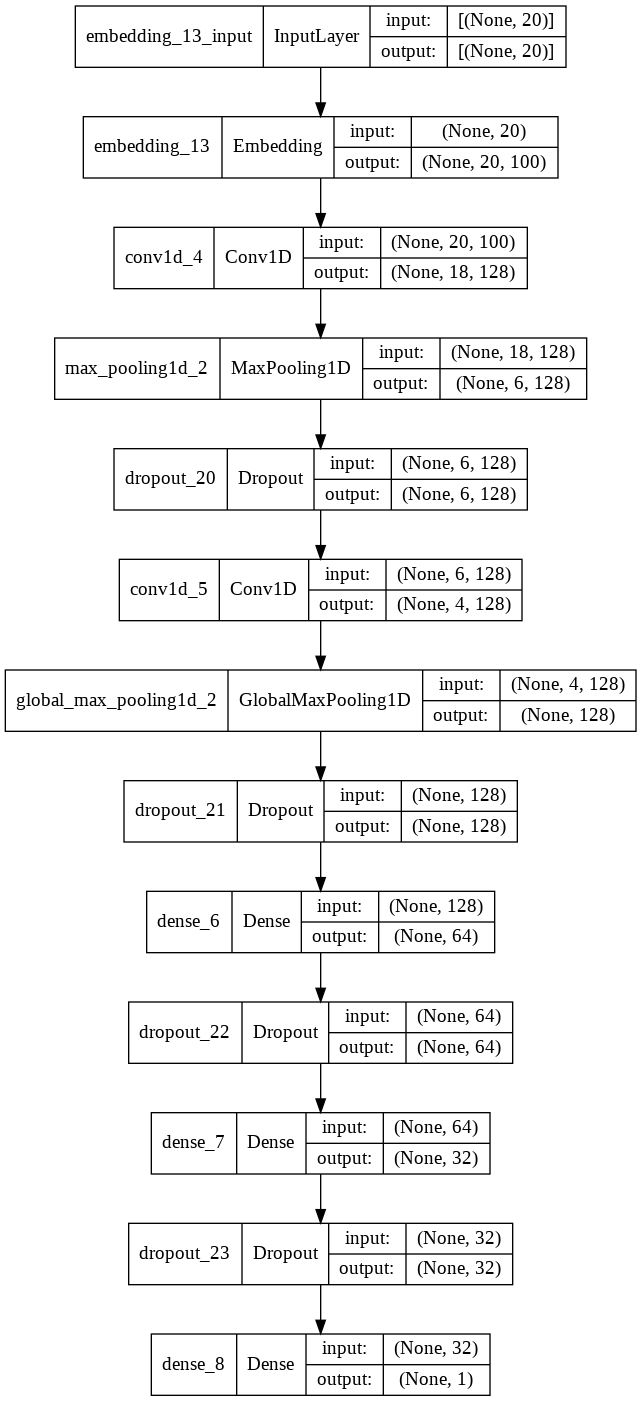

In [ ]:
plot_model(model3, "model3.png", show_shapes=True)

CNN output and confusion matrix

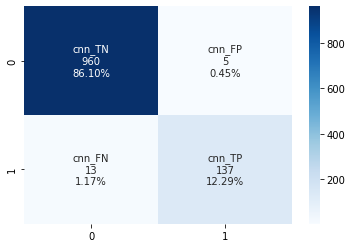

In [ ]:
cnn_pred = [1 if val > 0.5 else 0 for val in model3.predict(np.array(X_test))]

cnn_cm = metrics.confusion_matrix(y_test, cnn_pred)
# pd.DataFrame(data = cnn_cm, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

group_names = ['cnn_TN','cnn_FP','cnn_FN','cnn_TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cnn_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnn_cm.flatten()/np.sum(cnn_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
cnn_labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnn_cm, annot=cnn_labels, fmt='', cmap='Blues')

CNN output ROC curve

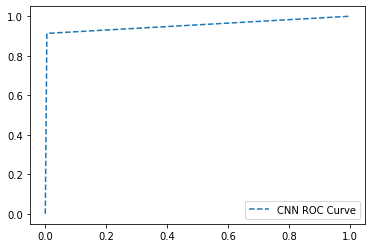

In [ ]:
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred)

plt.plot(cnn_fpr, cnn_tpr, linestyle='--', label='CNN ROC Curve')
plt.legend()

CNN output PR curve

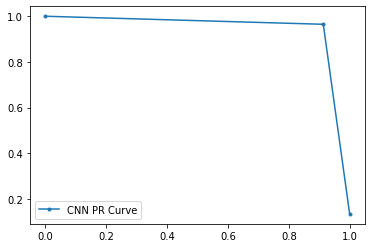

In [ ]:
cnn_precision, cnn_recall, _ = precision_recall_curve(y_test, cnn_pred)

plt.plot(cnn_recall, cnn_precision, marker='.', label='CNN PR Curve')
plt.legend()

Comparision of ROC curves between LSTM, GRU, Bi-LSTM, CNN

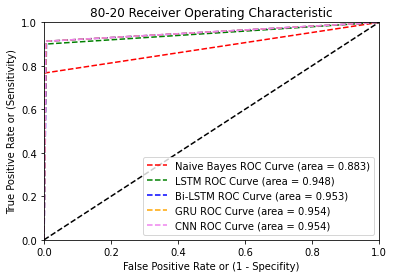

In [ ]:

nb_roc_auc = auc(nb_fpr, nb_tpr)
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)
gru_roc_auc = auc(gru_fpr, gru_tpr)
bilstm_roc_auc = auc(bilstm_fpr, bilstm_tpr)
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)

plt.plot(nb_fpr, nb_tpr, color= 'red', linestyle='--', label='Naive Bayes ROC Curve (area = %0.3f)' % nb_roc_auc)
plt.plot(lstm_fpr, lstm_tpr, color= 'green', linestyle='--', label='LSTM ROC Curve (area = %0.3f)' % lstm_roc_auc)
plt.plot(bilstm_fpr, bilstm_tpr, color= 'blue', linestyle='--', label='Bi-LSTM ROC Curve (area = %0.3f)' % bilstm_roc_auc)
plt.plot(gru_fpr, gru_tpr, color= 'orange', linestyle='--', label='GRU ROC Curve (area = %0.3f)' % gru_roc_auc)
plt.plot(cnn_fpr, cnn_tpr, color= 'violet', linestyle='--', label='CNN ROC Curve (area = %0.3f)' % cnn_roc_auc)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate or (1 - Specifity)')

plt.ylabel('True Positive Rate or (Sensitivity)')

plt.title('80-20 Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.show()

Comparision of PR curves between LSTM, GRU, Bi-LSTM, CNN

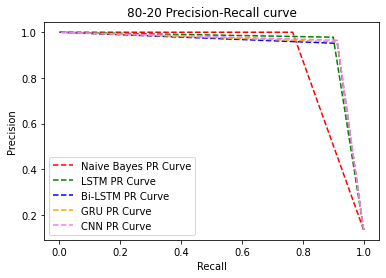

In [ ]:
plt.plot(nb_recall, nb_precision, color= 'red', linestyle='--', label='Naive Bayes PR Curve')
plt.plot(lstm_recall, lstm_precision, color= 'green', linestyle='--', label='LSTM PR Curve')
plt.plot(bilstm_recall, bilstm_precision, color= 'blue', linestyle='--', label='Bi-LSTM PR Curve')
plt.plot(gru_recall, gru_precision, color= 'orange', linestyle='--', label='GRU PR Curve')
plt.plot(cnn_recall, cnn_precision, color= 'violet', linestyle='--', label='CNN PR Curve')

plt.xlabel('Recall')

plt.ylabel('Precision')

plt.title('80-20 Precision-Recall curve')

plt.legend(loc="lower left")

plt.show()




Comparision of Metrics between LSTM, GRU, Bi-LSTM, CNN

In [ ]:
ndf = pd.DataFrame({"Models":[], "Accuracies": [], "Precision": [], "Recall": []})

ndf.loc[0, "Models"] = "Naive Bayes"
ndf.loc[0, "Accuracies"] = str((nb_cm[0][0] + nb_cm[1][1])/(nb_cm[0][0] + nb_cm[0][1] + nb_cm[1][0] + nb_cm[1][1]))
ndf.loc[0, "Precision"] = str((nb_cm[1][1])/(nb_cm[0][1] + nb_cm[1][1]))
ndf.loc[0, "Recall"] = str((nb_cm[1][1])/(nb_cm[1][0] + nb_cm[1][1]))

ndf.loc[1, "Models"] = "LSTM"
ndf.loc[1, "Accuracies"] = str((lstm_cm[0][0] + lstm_cm[1][1])/(lstm_cm[0][0] + lstm_cm[0][1] + lstm_cm[1][0] + lstm_cm[1][1]))
ndf.loc[1, "Precision"] = str((lstm_cm[1][1])/(lstm_cm[0][1] + lstm_cm[1][1]))
ndf.loc[1, "Recall"] = str((lstm_cm[1][1])/(lstm_cm[1][0] + lstm_cm[1][1]))

ndf.loc[2, "Models"] = "GRU"
ndf.loc[2, "Accuracies"] = str((gru_cm[0][0] + gru_cm[1][1])/(gru_cm[0][0] + gru_cm[0][1] + gru_cm[1][0] + gru_cm[1][1]))
ndf.loc[2, "Precision"] = str((gru_cm[1][1])/(gru_cm[0][1] + gru_cm[1][1]))
ndf.loc[2, "Recall"] = str((gru_cm[1][1])/(gru_cm[1][0] + gru_cm[1][1]))

ndf.loc[3, "Models"] = "Bi-Directional LSTM"
ndf.loc[3, "Accuracies"] = str((bilstm_cm[0][0] + bilstm_cm[1][1])/(bilstm_cm[0][0] + bilstm_cm[0][1] + bilstm_cm[1][0] + bilstm_cm[1][1]))
ndf.loc[3, "Precision"] = str((bilstm_cm[1][1])/(bilstm_cm[0][1] + bilstm_cm[1][1]))
ndf.loc[3, "Recall"] = str((bilstm_cm[1][1])/(bilstm_cm[1][0] + bilstm_cm[1][1]))

ndf.loc[4, "Models"] = "CNN"
ndf.loc[4, "Accuracies"] = str((cnn_cm[0][0] + cnn_cm[1][1])/(cnn_cm[0][0] + cnn_cm[0][1] + cnn_cm[1][0] + cnn_cm[1][1]))
ndf.loc[4, "Precision"] = str((cnn_cm[1][1])/(cnn_cm[0][1] + cnn_cm[1][1]))
ndf.loc[4, "Recall"] = str((cnn_cm[1][1])/(cnn_cm[1][0] + cnn_cm[1][1]))

ndf.head()


,Models,Accuracies,Precision,Recall
0,Naive Bayes,0.968609865470852,1.0,0.7666666666666667
1,LSTM,0.9838565022421525,0.9782608695652174,0.9
2,GRU,0.9829596412556054,0.958041958041958,0.9133333333333333
3,Bi-Directional LSTM,0.9820627802690582,0.9513888888888888,0.9133333333333333
4,CNN,0.9838565022421525,0.9647887323943662,0.9133333333333333


Comparision of Confusion matrices between LSTM, GRU, Bi-LSTM, CNN

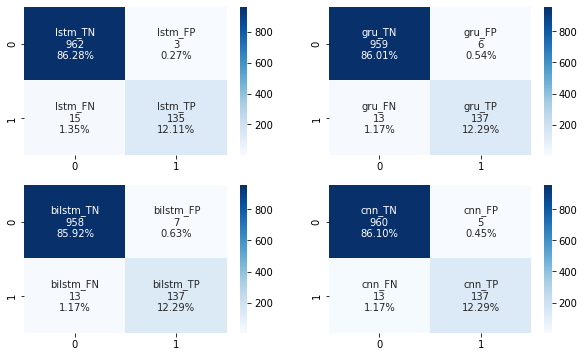

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

sns.heatmap(ax=axes[0,0], data=lstm_cm, annot=lstm_labels, fmt='', cmap='Blues')
sns.heatmap(ax=axes[0,1], data=gru_cm, annot=gru_labels, fmt='', cmap='Blues' )
sns.heatmap(ax=axes[1,0], data=bilstm_cm, annot=bilstm_labels, fmt='', cmap='Blues' )
sns.heatmap(ax=axes[1,1], data=cnn_cm, annot=cnn_labels, fmt='', cmap='Blues')
